In [5]:
import pandas as pd

# Mature no children

In [6]:
# load preprocessed data
path = './preprocessed_data/df_mature_no_children_no_split.pickle'
data = pd.read_pickle(path)
print(*data.keys(), sep='\n')

AGE OF R 79
# OF SIBS 79
FREQ RELGS ATTENDANCE R 79
# CHILDREN IDEAL FOR FAMILY 79
TOT# CHILDREN EXPCT HAVE 79
TOT NET FAMILY INC P-C YR 79
AREA RESIDENCE @ AGE 14 URBAN/RURAL 79_IN COUNTRY-NOT FARM
AREA RESIDENCE @ AGE 14 URBAN/RURAL 79_IN TOWN OR CITY
AREA RESIDENCE @ AGE 14 URBAN/RURAL 79_ON FARM OR RANCH
1ST/ONLY RACL/ETHNIC ORIGIN 79_AMERICAN
1ST/ONLY RACL/ETHNIC ORIGIN 79_ASIAN INDIAN
1ST/ONLY RACL/ETHNIC ORIGIN 79_BLACK
1ST/ONLY RACL/ETHNIC ORIGIN 79_CHICANO
1ST/ONLY RACL/ETHNIC ORIGIN 79_CHINESE
1ST/ONLY RACL/ETHNIC ORIGIN 79_CUBAN
1ST/ONLY RACL/ETHNIC ORIGIN 79_ENGLISH
1ST/ONLY RACL/ETHNIC ORIGIN 79_FILIPINO
1ST/ONLY RACL/ETHNIC ORIGIN 79_FRENCH
1ST/ONLY RACL/ETHNIC ORIGIN 79_GERMAN
1ST/ONLY RACL/ETHNIC ORIGIN 79_GREEK
1ST/ONLY RACL/ETHNIC ORIGIN 79_HAWAIIAN, P.I.
1ST/ONLY RACL/ETHNIC ORIGIN 79_INDIAN-AMERICAN OR NATIVE AMERICAN
1ST/ONLY RACL/ETHNIC ORIGIN 79_IRISH
1ST/ONLY RACL/ETHNIC ORIGIN 79_ITALIAN
1ST/ONLY RACL/ETHNIC ORIGIN 79_JAPANESE
1ST/ONLY RACL/ETHNIC ORIGIN 79_MEX

In [3]:
X_train = data['X_train_normalized']
X_test = data['X_test_normalized']
Y_train = data['Y_train']
Y_test = data['Y_test']
T_train = data['T_train']
T_test = data['T_test']

T_name = T_train.name
Y_name = Y_train.name
covariate_names = X_train.columns.to_list()

KeyError: 'T_train'

In this part we assume that the treatment is binary. This is implemented using a threshold which is the median.

In [33]:
threshold = 2
T_train = T_train.apply(lambda x: 0 if x <= threshold else 1)
T_test = T_test.apply(lambda x: 0 if x <= threshold else 1)

In [34]:
# Rebuild the full DataFrame
train_data = X_train.copy()
train_data[T_name] = T_train
train_data[Y_name] = Y_train

In [35]:
# Create a CausalModel with the training data
from dowhy import CausalModel

model = CausalModel(
    data=train_data,
    treatment=T_name,
    outcome=Y_name,
    common_causes=covariate_names
)


## DML

In [37]:
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression

# Define models for outcome (Y) and treatment (T)
model_y = RandomForestRegressor()    # Flexible model for outcome regression
model_t = RandomForestClassifier()    # Flexible model for treatment regression

# Initialize the LinearDML estimator (supports confidence intervals)
linear_dml_model = LinearDML(
    model_y=model_y,                # Model for outcome regression
    model_t=model_t,                # Model for treatment regression
    discrete_treatment=True        # Set to True if treatment is binary
)

# Fit the LinearDML model on the training data
linear_dml_model.fit(Y_train, T_train, X=X_train)

# Estimate the Average Treatment Effect (ATE) for the entire dataset
ate = linear_dml_model.ate(X_test)

# Estimate the confidence intervals for the ATE
ate_lower, ate_upper = linear_dml_model.ate_interval(X_test)

# Output the estimated ATE and its confidence intervals
print(f"Estimated ATE: {ate}")
print(f"Confidence Interval for ATE: [{ate_lower}, {ate_upper}]")


Not all column names are strings. Coercing to strings for now.


Estimated ATE: 0.07035049092063528
Confidence Interval for ATE: [-0.10243564751375765, 0.243136629355028]


Co-variance matrix is underdetermined. Inference will be invalid!


### DML Evaluation

In [38]:
# from sklearn.metrics import r2_score
# 
# # Evaluate the outcome model (model_y)
# y_pred = linear_dml_model.model_y.predict(X_test)  # Access fitted model for outcome
# r2_y = r2_score(Y_test, y_pred)  # Compute R² for the outcome model
# print(f"R² for the outcome model: {r2_y}")
# 
# # Evaluate the treatment model (model_t)
# t_pred = linear_dml_model.model_t.predict(X_test)  # Access fitted model for treatment
# r2_t = r2_score(T_test, t_pred)  # Compute R² for the treatment model
# print(f"R² for the treatment model: {r2_t}")

## S-Learner

In [39]:
from econml.metalearners import SLearner
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split


# Define XGBoost for outcome prediction
xgb_model = XGBRegressor()

# Initialize the S-Learner using XGBoost
s_learner = SLearner(overall_model=xgb_model)

# Fit the S-Learner
s_learner.fit(Y_train, T_train, X=X_train)

# Estimate the ATE using the fitted model
ate_s_learner = s_learner.ate(X_test)

print(f"S-Learner ATE: {ate_s_learner}")


S-Learner ATE: 0.17356466461858408


Not all column names are strings. Coercing to strings for now.


## T-Learner

In [40]:
from econml.metalearners import TLearner
from xgboost import XGBRegressor

# Define XGBoost for both models
xgb_model = XGBRegressor()

# Initialize the T-Learner with XGBoost
t_learner = TLearner(models=XGBRegressor())

# Fit the T-Learner
t_learner.fit(Y_train, T_train, X=X_train)

# Estimate the ATE using the T-Learner
ate_t_learner = t_learner.ate(X_test)

print(f"T-Learner ATE: {ate_t_learner}")


Not all column names are strings. Coercing to strings for now.


T-Learner ATE: 0.06312569668474753


## X-learner

In [41]:
from econml.metalearners import XLearner
from xgboost import XGBRegressor

# Define XGBoost for both models
xgb_model = XGBRegressor()

# Initialize the X-Learner with XGBoost
x_learner = XLearner(models=XGBRegressor())

# Fit the X-Learner
x_learner.fit(Y_train, T_train, X=X_train)

# Estimate the ATE using the X-Learner
ate_x_learner = x_learner.ate(X_test)

print(f"X-Learner ATE: {ate_x_learner}")


Not all column names are strings. Coercing to strings for now.


X-Learner ATE: 0.08665650472847702


## IPW

In [42]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

# Fit a propensity score model (XGBoost or Logistic Regression)
propensity_model = LogisticRegression()
propensity_model.fit(X_train, T_train)

# Predict propensity scores (probabilities of treatment)
propensity_scores = propensity_model.predict_proba(X_test)[:, 1]  # Prob of being treated (T=1)

# Compute the inverse propensity weights
epsilon = 1e-3
weights_treated = 1 / (propensity_scores[T_test == 1] + epsilon)
weights_control = 1 / (propensity_scores[T_test == 0] + epsilon)

# Apply IPW to estimate the ATE
# Separate treated and control groups
Y_treated = Y_test[T_test == 1]
Y_control = Y_test[T_test == 0]

# Weighted means of outcomes
weighted_mean_treated = np.average(Y_treated, weights=weights_treated)
weighted_mean_control = np.average(Y_control, weights=weights_control)

# ATE estimation
ate_ipw = weighted_mean_treated - weighted_mean_control

print(f"Estimated ATE using IPW: {ate_ipw}")


Estimated ATE using IPW: 0.9009580852970198


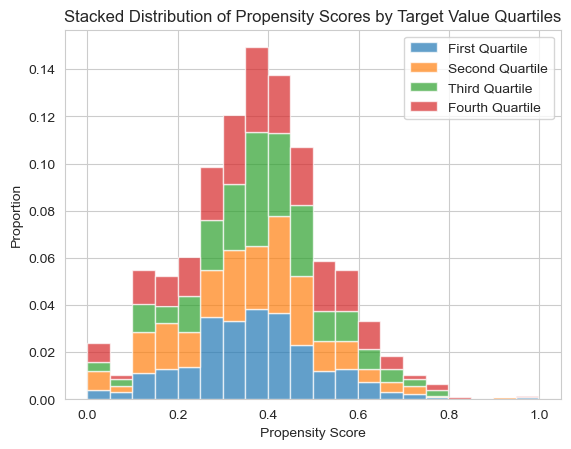

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Sort indices based on the target values (Y_train)
sorted_indices = np.argsort(Y_train)

# Divide data into quartiles based on sorted target values
quartile_size = len(Y_train) // 4
first_quartile_indices = sorted_indices[:quartile_size]
second_quartile_indices = sorted_indices[quartile_size:2*quartile_size]
third_quartile_indices = sorted_indices[2*quartile_size:3*quartile_size]
fourth_quartile_indices = sorted_indices[3*quartile_size:]

# Use iloc to retain feature names when slicing
propensity_scores_first_quartile = propensity_model.predict_proba(X_train.iloc[first_quartile_indices])[:, 1]
propensity_scores_second_quartile = propensity_model.predict_proba(X_train.iloc[second_quartile_indices])[:, 1]
propensity_scores_third_quartile = propensity_model.predict_proba(X_train.iloc[third_quartile_indices])[:, 1]
propensity_scores_fourth_quartile = propensity_model.predict_proba(X_train.iloc[fourth_quartile_indices])[:, 1]

# Calculate the total number of samples for weights normalization
total_samples = len(first_quartile_indices) + len(second_quartile_indices) + len(third_quartile_indices) + len(fourth_quartile_indices)

# Compute weights for each group so that their relative size is maintained
weights_first = np.ones_like(propensity_scores_first_quartile) / total_samples
weights_second = np.ones_like(propensity_scores_second_quartile) / total_samples
weights_third = np.ones_like(propensity_scores_third_quartile) / total_samples
weights_fourth = np.ones_like(propensity_scores_fourth_quartile) / total_samples

# Plot stacked histograms for quartiles with relative magnitude
plt.hist(
    [propensity_scores_first_quartile, propensity_scores_second_quartile, propensity_scores_third_quartile, propensity_scores_fourth_quartile], 
    bins=20, 
    weights=[weights_first, weights_second, weights_third, weights_fourth],  # Maintain relative sizes
    alpha=0.7, 
    label=['First Quartile', 'Second Quartile', 'Third Quartile', 'Fourth Quartile'],
    stacked=True,
    density=False
)

# Add labels and legend
plt.title('Stacked Distribution of Propensity Scores by Target Value Quartiles')
plt.xlabel('Propensity Score')
plt.ylabel('Proportion')
plt.legend(loc='best')

# Show the plot
plt.show()


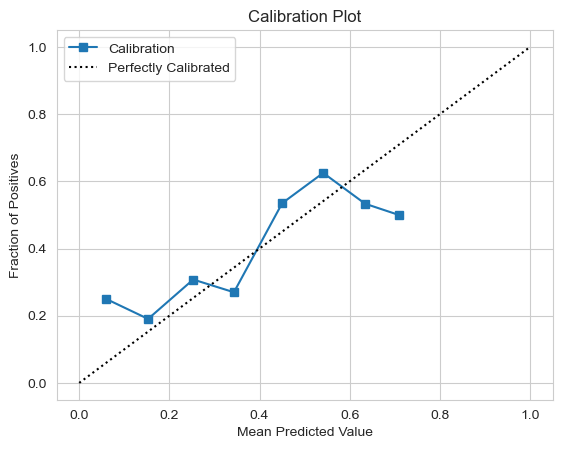

In [44]:
from sklearn.calibration import calibration_curve

# Get predicted propensity scores
propensity_scores = propensity_model.predict_proba(X_test)[:, 1]

# Calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(T_test, propensity_scores, n_bins=10)

# Plot calibration curve
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Calibration")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Value")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.title("Calibration Plot")
plt.show()


## DR

In [29]:
from econml.dr import DRLearner
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor, XGBClassifier

# Define models for propensity score (treatment model) and outcome model
model_t = LogisticRegression()  # Propensity score model for binary treatment
model_y = XGBRegressor()   # Outcome model for continuous outcomes

# Initialize the DR Learner
# Ensure cross-fitting is enabled
dr_learner = DRLearner(
    model_propensity=model_t, 
    model_regression=model_y,
    cv=5  # 5-fold cross-fitting
)

# Fit the DR Learner on training data
dr_learner.fit(Y_train, T_train, X=X_train)

# Estimate the Average Treatment Effect (ATE) using the fitted DR Learner
ate_dr = dr_learner.ate(X_test)

# Output the estimated ATE
print(f"Estimated ATE using Doubly Robust Learner: {ate_dr}")


Not all column names are strings. Coercing to strings for now.


Estimated ATE using Doubly Robust Learner: 636.6613529594338


Co-variance matrix is underdetermined. Inference will be invalid!
